Loading preprocessed data...
Data loaded successfully.
Data shape: (1190369, 9)
   waist Acceleration X (m/s^2)  waist Acceleration Y (m/s^2)  \
0                     -0.489143                     -0.143504   
1                     -0.490534                     -0.142446   
2                     -0.491033                     -0.141540   
3                     -0.490211                     -0.140873   
4                     -0.488028                     -0.140400   

   waist Acceleration Z (m/s^2)  waist Angular Velocity X (rad/s)  \
0                     -0.619714                          0.037083   
1                     -0.623439                          0.043843   
2                     -0.626849                          0.050097   
3                     -0.629658                          0.055464   
4                     -0.631694                          0.059889   

   waist Angular Velocity Y (rad/s)  waist Angular Velocity Z (rad/s)  \
0                         -0.343827      

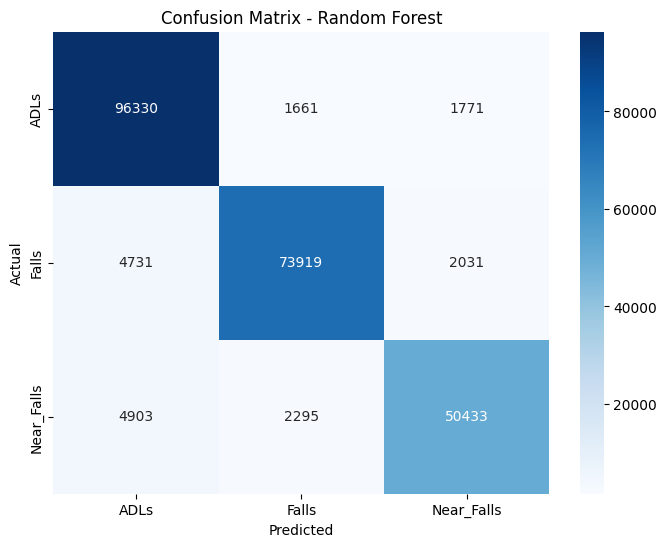


Training the XGBoost model...


C:\Users\lankh\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [09:34:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost training completed.

Evaluating the XGBoost model on the test set...

Classification Report for XGBoost:
              precision    recall  f1-score   support

        ADLs       0.62      0.86      0.72     99762
       Falls       0.78      0.55      0.64     80681
  Near_Falls       0.58      0.42      0.49     57631

    accuracy                           0.65    238074
   macro avg       0.66      0.61      0.62    238074
weighted avg       0.66      0.65      0.64    238074

Confusion Matrix for XGBoost:
[[85964  5427  8371]
 [27205 43993  9483]
 [26542  6825 24264]]
XGBoost Accuracy: 0.65


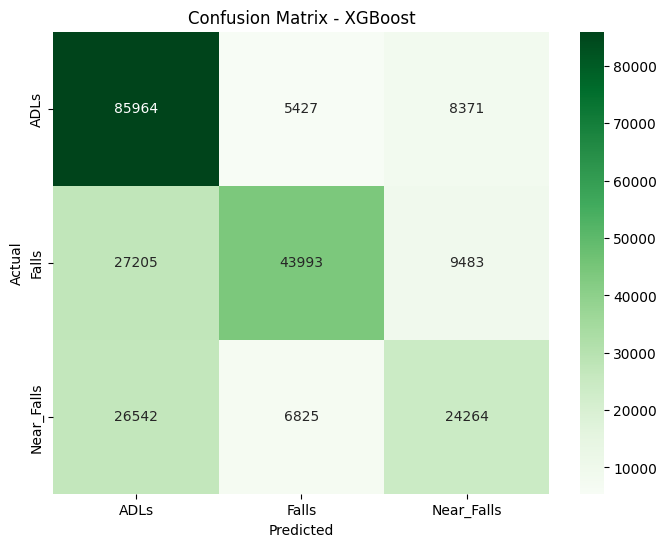


Saving the trained Random Forest and XGBoost models...
Trained Random Forest model saved to C:\Users\lankh\Downloads\SFU-IMU Dataset\IMU Dataset\random_forest_fall_detection_model.joblib


NameError: name 'xgb_model_path' is not defined

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb

# ---------------------------------------------
# Configuration
# ---------------------------------------------

# Define the base directory where the preprocessed data is located
BASE_DIR = 'C:\\Users\\lankh\\Downloads\\SFU-IMU Dataset\\IMU Dataset'  # Replace with your actual path

# Define the preprocessed data file
PREPROCESSED_FILE = 'preprocessed_imu_data.csv'
preprocessed_path = os.path.join(BASE_DIR, PREPROCESSED_FILE)

# Define the model saving paths
RF_MODEL_FILENAME = 'random_forest_fall_detection_model.joblib'
RF_model_path = os.path.join(BASE_DIR, RF_MODEL_FILENAME)

XGB_MODEL_FILENAME = 'xgboost_fall_detection_model.joblib'
XGB_model_path = os.path.join(BASE_DIR, XGB_MODEL_FILENAME)

# Define label encoder and scaler saving paths
LABEL_ENCODER_FILENAME = 'label_encoder.pkl'
label_encoder_path = os.path.join(BASE_DIR, LABEL_ENCODER_FILENAME)

SCALER_FILENAME = 'scaler.pkl'
scaler_path = os.path.join(BASE_DIR, SCALER_FILENAME)

# Define feature columns
feature_columns = [
    'waist Acceleration X (m/s^2)',
    'waist Acceleration Y (m/s^2)',
    'waist Acceleration Z (m/s^2)',
    'waist Angular Velocity X (rad/s)',
    'waist Angular Velocity Y (rad/s)',
    'waist Angular Velocity Z (rad/s)'
]

# ---------------------------------------------
# 1. Load Preprocessed Data
# ---------------------------------------------

print("Loading preprocessed data...")
data = pd.read_csv(preprocessed_path)
print("Data loaded successfully.")
print(f"Data shape: {data.shape}")
print(data.head())

# ---------------------------------------------
# 2. Split Features and Labels
# ---------------------------------------------

print("\nSplitting features and labels...")
X = data[feature_columns]
y = data['Activity_Label']  # Ensure this column exists and is correctly encoded
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# ---------------------------------------------
# 3. Encode Labels (If Necessary)
# ---------------------------------------------

# Check if labels are already numeric
if y.dtype == 'object' or y.dtype.name == 'category':
    print("\nEncoding labels...")
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    # Save the label encoder
    joblib.dump(label_encoder, label_encoder_path)
    print(f"Label encoder saved to {label_encoder_path}")
else:
    print("\nLabels are already encoded numerically.")

# ---------------------------------------------
# 4. Split into Training and Testing Sets
# ---------------------------------------------

print("\nSplitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# ---------------------------------------------
# 5. Feature Scaling (Standardization)
# ---------------------------------------------

print("\nApplying feature scaling...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for future use
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# ---------------------------------------------
# 6. Train the Random Forest Model
# ---------------------------------------------

print("\nTraining the Random Forest model...")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train_scaled, y_train)
print("Random Forest training completed.")

# ---------------------------------------------
# 7. Evaluate the Random Forest Model
# ---------------------------------------------

print("\nEvaluating the Random Forest model on the test set...")
y_pred_rf = rf_classifier.predict(X_test_scaled)

# Classification Report
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=['ADLs', 'Falls', 'Near_Falls']))

# Confusion Matrix
print("Confusion Matrix for Random Forest:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['ADLs', 'Falls', 'Near_Falls'], 
            yticklabels=['ADLs', 'Falls', 'Near_Falls'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# ---------------------------------------------
# 8. Train the XGBoost Model
# ---------------------------------------------

print("\nTraining the XGBoost model...")
xgb_classifier = xgb.XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    random_state=42, 
    n_jobs=-1, 
    use_label_encoder=False, 
    eval_metric='mlogloss'
)
xgb_classifier.fit(X_train_scaled, y_train)
print("XGBoost training completed.")

# ---------------------------------------------
# 9. Evaluate the XGBoost Model
# ---------------------------------------------

print("\nEvaluating the XGBoost model on the test set...")
y_pred_xgb = xgb_classifier.predict(X_test_scaled)

# Classification Report
print("\nClassification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=['ADLs', 'Falls', 'Near_Falls']))

# Confusion Matrix
print("Confusion Matrix for XGBoost:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(cm_xgb)

# Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.2f}")

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['ADLs', 'Falls', 'Near_Falls'], 
            yticklabels=['ADLs', 'Falls', 'Near_Falls'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# ---------------------------------------------
# 10. Save the Trained Models
# ---------------------------------------------

print("\nSaving the trained Random Forest and XGBoost models...")
joblib.dump(rf_classifier, RF_model_path)
print(f"Trained Random Forest model saved to {RF_model_path}")

joblib.dump(xgb_classifier, XGB_model_path)
print(f"Trained XGBoost model saved to {XGB_model_path}")